In [17]:
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
mat = scipy.io.loadmat('ch_cell.mat')

In [9]:
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'X_rx', 'Y', 'Y_rx', 'a', 'ans', 'b', 'None', 'ch_cell', 'coord', 'crd', 'd', 'dire', 'dist', 'i', 'j', 'lat_e', 'lat_s', 'lon_e', 'lon_s', 'n', 'n_rx', 'n_tx', 'nr', 'nt', 'r', 'r1', 'ray', 'ray_sample', 'rays', 'sig', 't', 'x', 'y', '__function_workspace__'])

In [13]:
ch = mat['ch_cell']
dist =mat['dist']

In [91]:
ch[2,0][:,0].shape

(100,)

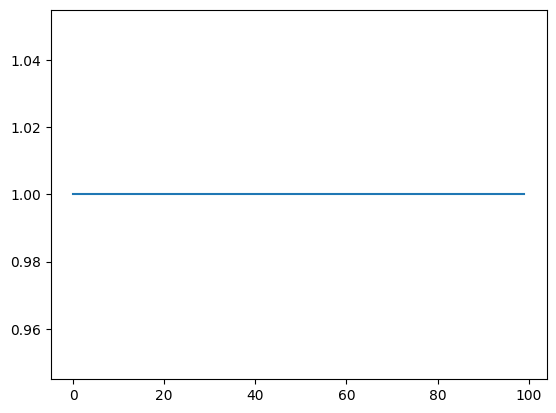

In [37]:
plt.plot(np.abs(ch[2,0]))

In [42]:
ch[2, 0]

array([[-0.97417595-0.2257902j ],
       [-0.97417653-0.22578769j],
       [-0.97417712-0.22578518j],
       [-0.9741777 -0.22578267j],
       [-0.97417828-0.22578016j],
       [-0.97417886-0.22577765j],
       [-0.97417944-0.22577514j],
       [-0.97418002-0.22577263j],
       [-0.97418061-0.22577012j],
       [-0.97418119-0.22576761j],
       [-0.97418177-0.2257651j ],
       [-0.97418235-0.22576258j],
       [-0.97418293-0.22576007j],
       [-0.97418352-0.22575756j],
       [-0.9741841 -0.22575505j],
       [-0.97418468-0.22575254j],
       [-0.97418526-0.22575003j],
       [-0.97418584-0.22574752j],
       [-0.97418642-0.22574501j],
       [-0.97418701-0.2257425j ],
       [-0.97418759-0.22573999j],
       [-0.97418817-0.22573748j],
       [-0.97418875-0.22573497j],
       [-0.97418933-0.22573246j],
       [-0.97418991-0.22572995j],
       [-0.9741905 -0.22572744j],
       [-0.97419108-0.22572493j],
       [-0.97419166-0.22572242j],
       [-0.97419224-0.22571991j],
       [-0.974

In [150]:
len(invalid)

1334

In [147]:
tmp = np.zeros_like(ch)
m, n = ch.shape
invalid = []

for i in range(m):
    for j in range(n):
        p,  q = ch[i, j].shape
        if q > 1:
            tmp[i, j] = ch[i, j][:,0]
        else:
            if q == 1:
                invalid.append([i, j])
                tmp[i, j] = np.zeros(100)
            else:
                tmp[i, j] = ch[i, j]
             

In [144]:
ch[5, 0].shape, ch[6, 0].shape

((100, 8), (100, 1))

In [125]:
tmp[0][0]==0, invalid

(array([ True]), [])

/home/yuk/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


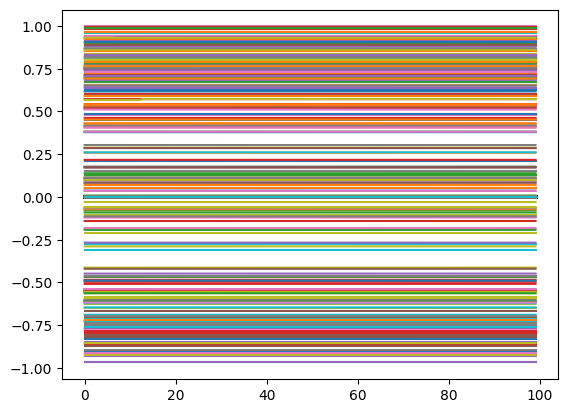

In [160]:
for i in tmp[:,1]:
    plt.plot(np.abs(i))

for i in tmp[:,0]:
    plt.plot(i)

for i in tmp[:,2]:
    plt.plot(i)

for i in tmp[:,3]:
    plt.plot(i)

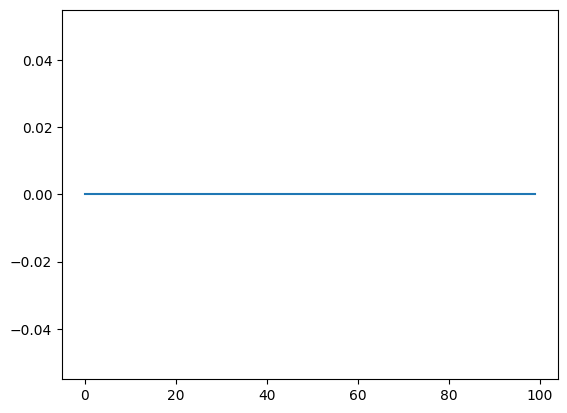

In [165]:
plt.plot(tmp[106,0])

In [15]:
ch.shape, dist.shape

((400, 4), (400, 4))